## SIFT + Bag-Of-Visual_Words + SVM

В этом ноутбуке попробуем обучить классификатор изображений, используя алгоритм SIFT, обернув результат его работы в модель Bag-Of-Visual-Words, а затем полученные данные скормить модели SVM.

В нашем тренировочном датасете ~39к изображений дорожных знаков довольно скудного качества, каждый из которых принадлежит одному из 43 классов. 

In [1]:
import pathlib
import time

import cv2 as cv
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from scipy.stats import uniform as sp_uniform

%matplotlib inline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Предобработка изображений

В нашем датасете очень много изображений плохого качества, например смазанные, затемененные, низкого разрешения. Чтобы SIFT смог наилучшим образом извлечь фичи из таких изображений, необходимо их предварительно обработать.

Мы переведем изображения в YCrCb, тем самым разделим яркость и цвет изображения, и применим выравнивание гистограммы к каналу Y, отвечающему за яркость. Далее сделаем картинку черно-белой и нормализуем ее. После этого приведем каждую картинку к размеру 32x32, применяя разную интерполяцию в зависимости от того, сжимаем мы картинку или растягиваем. Ниже приведены примеры картинок на каждом этапе предобработки.

In [2]:
df_train_info = pd.read_csv("Train.csv")
df_train_info.sample(5)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
10905,45,45,5,5,40,40,7,Train/7/00007_00006_00015.png
9894,56,56,6,6,51,51,5,Train/5/00005_00048_00024.png
34884,50,49,5,6,45,44,35,Train/35/00035_00022_00025.png
35409,43,43,5,5,38,38,36,Train/36/00036_00000_00010.png
26884,42,39,6,6,37,34,19,Train/19/00019_00004_00004.png


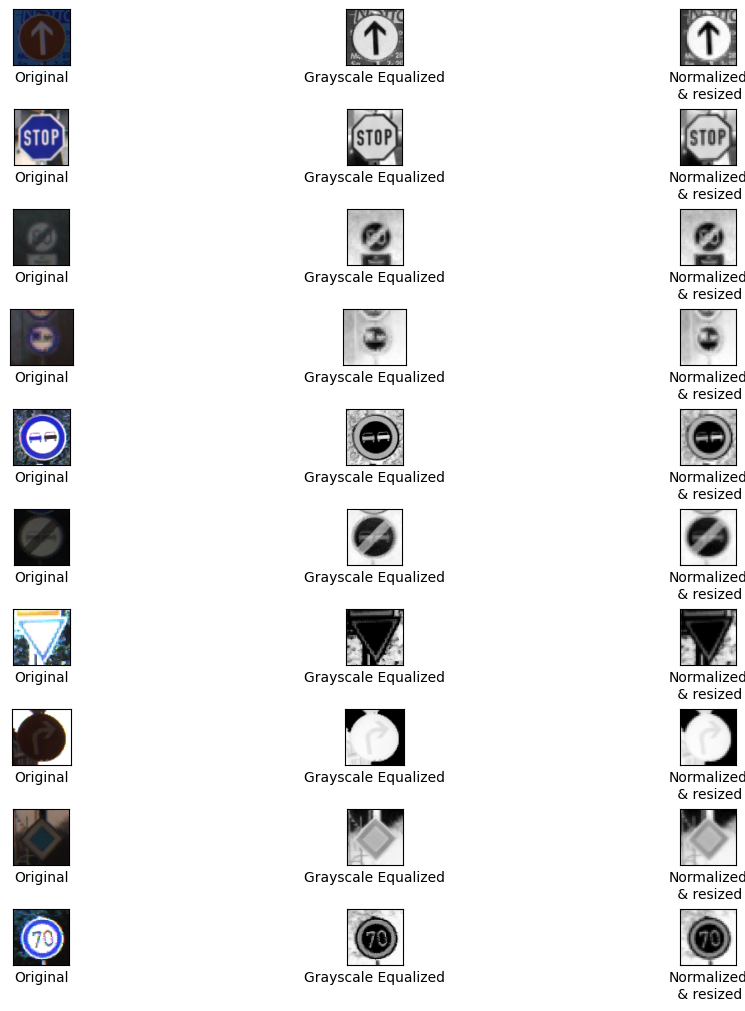

In [4]:
plt.figure(figsize = (10, 10), layout='constrained')

i = 0

img_shape = (32, 32)

for img_path in df_train_info.sample(10).Path.values:

    img_full_path = img_path

    # Read image
    img = cv.imread(img_full_path)

    plt.subplot(10, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel('Original')
    i+=1

    # Equalize hist
    ycrcb_img = cv.cvtColor(img, cv.COLOR_BGR2YCrCb)
    ycrcb_img[:, :, 0] = cv.equalizeHist(ycrcb_img[:, :, 0])
    grayimg = cv.cvtColor(ycrcb_img, cv.COLOR_YCrCb2BGR)
    grayimg = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    plt.subplot(10, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(grayimg, cmap=plt.cm.binary)
    plt.xlabel('Grayscale Equalized')
    i+=1

    # Normalize image
    normalized_grayimg = np.zeros(grayimg.shape)
    normalized_grayimg = cv.normalize(grayimg,  normalized_grayimg, 0, 255, cv.NORM_MINMAX)

    # Resize image to 32x32. Use different interpolation whether we shrink or enlarging the image.
    if normalized_grayimg.size >= 1024:
        normalized_grayimg = cv.resize(normalized_grayimg, img_shape, interpolation=cv.INTER_AREA)
    else:
        normalized_grayimg = cv.resize(normalized_grayimg, img_shape, interpolation=cv.INTER_CUBIC)

    plt.subplot(10, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(normalized_grayimg, cmap=plt.cm.binary)
    plt.xlabel('Normalized\n & resized')
    i+=1

plt.show()

Теперь визуализируем, как вообще выглядит результат работы SIFT

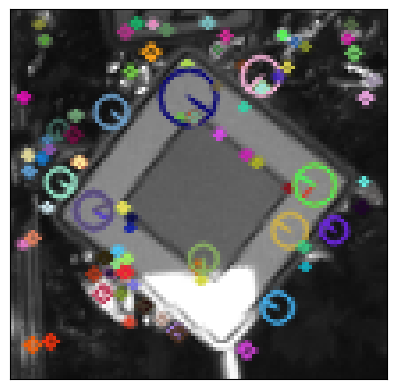

In [12]:
rand_img = df_train_info.sample(1).Path.values[0]

img = cv.imread(rand_img)
grayimg = cv.cvtColor(img, cv.COLOR_BGR2GRAY)


sift = cv.SIFT_create()
kp = sift.detect(grayimg,None)
img = cv.drawKeypoints(grayimg,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# cv.imwrite('sift_keypoints.jpg',img)

plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(img, cmap=plt.cm.binary)

Реализуем функцию для предобработки картинок, так как выполнять нам ее надо будет несколько раз.

In [4]:
def preprocess_image(img: np.array, img_shape: tuple) -> np.array:

    # Equalize histogram, convert to gray
    ycrcb_img = cv.cvtColor(img, cv.COLOR_BGR2YCrCb)
    ycrcb_img[:, :, 0] = cv.equalizeHist(ycrcb_img[:, :, 0])
    bgr_img = cv.cvtColor(ycrcb_img, cv.COLOR_YCrCb2BGR)
    gray_img = cv.cvtColor(bgr_img, cv.COLOR_BGR2GRAY)
    
    # Normalize image
    normalized_gray_img = np.zeros(gray_img.shape)
    normalized_gray_img = cv.normalize(gray_img,  normalized_gray_img, 0, 255, cv.NORM_MINMAX)

    # Resize image to img_shape. Use different interpolation whether we shrink or enlarging the image.
    if normalized_gray_img.size >= np.prod(np.array(img_shape)):
        normalized_gray_img = cv.resize(normalized_gray_img, img_shape, interpolation = cv.INTER_AREA)
    else:
        normalized_gray_img = cv.resize(normalized_gray_img, img_shape, interpolation = cv.INTER_CUBIC)

    return normalized_gray_img

# Создадим мешок с визуальными словами

Для начала мы достанем фичи при помощи SIFT для каждой из картинок из тренировочного датасета. SIFT ищет на картинке ключевые точки (key points), каждая из которых в результате кодируется дескриптором. Дескриптор представляет из себя вектор, размерностью 128. Для разных картинок может быть разное количество ключевых точек, для некоторых их может не быть вообще.

После того, как мы получили набор дескрипторов для всех картинок, кластеризуем его при помощи K-means, получив $k$ центров кластеров. Теперь можно начинать формировать данные для обучения SVM, будем делать это следующим образом. Снова получим дескрипторы для каждой картинки из тренировочного набора. Допустим, мы получили $\{x_1, x_2, ..., x_i\}$ набор дескрипторов для какой-то картинки $U$, где каждый $x_n$ - это вектор размерностью 128. Теперь инициализируем нулевой вектор $N$ размерностью $k$ (где $k$ - это количество центров кластеров в нашем K-means). Для каждого дескриптора будем искать ближайший $j-й$ центр кластера и увеличивать $j-й$ элемент вектора $N$ на 1. Эту процедуру проделаем для каждой картинки, сформировав в итоге тренировочную матрицу объект-признак размером $n-картинок \times k-признаков$. 

Формируем набор дескрипторов всех картинок из тренировочного датасета.

In [5]:
local_data_path = "../data"

# Empty list to append descriptors to
preprocessed_imgs = []

for img_path in tqdm(df_train_info.Path.values):
    # Making full path to img
    img_full_path = local_data_path + "/" + img_path

    # Read image
    img = cv.imread(img_full_path)
    # Preprocess image
    prep_img = preprocess_image(img, (32, 32))
    # Extracting features
    sift = cv.SIFT_create(sigma=1.0)
    kp, des = sift.detectAndCompute(prep_img, None)

    if des is None:
        continue

    preprocessed_imgs.append(des)

  0%|          | 0/39209 [00:00<?, ?it/s]

In [6]:
descriptors = np.vstack(preprocessed_imgs)
descriptors.shape

(1264929, 128)

Теперь кластеризируем наши дескрипторы. Количество кластеров примем как $n-классов \times 15$.

In [7]:
kmeans = KMeans(n_clusters=43*15, random_state=42, n_init='auto').fit(descriptors)

Теперь у нас есть тот самый Bag-Of-Visual-Words. Заново найдем дескрипторы для каждой картинки и сформируем новый набор данных по вышеописанной логике.

In [8]:
X_train = np.zeros((df_train_info.Path.values.shape[0], 43*15))

for i, img_path in tqdm(enumerate(df_train_info.Path.values)):
    # Making full path to img
    img_full_path = local_data_path + "/" + img_path

    # Read image
    img = cv.imread(img_full_path)
    # Preprocess image
    prep_img = preprocess_image(img, (32, 32))
    # Extracting features
    # sift = cv.SIFT_create(contrastThreshold=0.01, sigma=1.0)
    sift = cv.SIFT_create(sigma=1.0)
    kp, des = sift.detectAndCompute(prep_img, None)

    try:
        closest_idx = kmeans.predict(des)
    except ValueError as ve:
        # Skipping when des is empty
        continue

    for idx in closest_idx:
        X_train[i, idx] += 1

0it [00:00, ?it/s]

Сейчас у нас все классы сгруппированы, то есть в нашем наборе они идут один за одним. Перемешаем их.

In [9]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, df_train_info.ClassId.values, random_state=42)

In [10]:
X_train.shape

(39209, 645)

Сразу же подготовим тестовый датасет аналогичным образом.

In [11]:
df_test_info = pd.read_csv("../data/Test.csv")
df_test_info.sample(5)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
3604,53,53,5,5,48,48,2,Test/03604.png
9130,177,151,15,13,162,138,13,Test/09130.png
9083,59,57,5,6,54,52,25,Test/09083.png
10052,50,48,6,5,45,43,13,Test/10052.png
5217,27,29,6,6,22,24,17,Test/05217.png


In [12]:
X_test = np.zeros((df_test_info.Path.values.shape[0], 43*15))

for i, img_path in tqdm(enumerate(df_test_info.Path.values)):
    # Making full path to img
    img_full_path = local_data_path + "/" + img_path

    # Reading, graying, resizing and hist equalizing
    img = cv.imread(img_full_path)
    # Preprocess image
    prep_img = preprocess_image(img, (32, 32))

    # Extracting features
    sift = cv.SIFT_create(sigma=1.0)
    kp, des = sift.detectAndCompute(prep_img, None)

    try:
        closest_idx = kmeans.predict(des)
    except ValueError as ve:
        # Skipping when des is empty
        continue

    for idx in closest_idx:
        X_test[i, idx] += 1

0it [00:00, ?it/s]

In [13]:
from sklearn.utils import shuffle
X_test, y_test = shuffle(X_test, df_test_info.ClassId.values, random_state=42)

In [14]:
X_test.shape

(12630, 645)

# Обучим классификатор SVM

Сначала прогоним модель на кросс валидации, оценивать будем с помощью accuracy. Параметры SVM стандартные, за исключением типа ядра, эмпирически выяснено, что лучше всего в данном случае подходит ядро 'rbf'.

In [15]:
n_estimators = 10
# clf = BaggingClassifier(SVC(kernel='linear', probability=True), max_samples=1.0 / n_estimators, n_estimators=n_estimators)
clf = SVC(kernel='rbf', probability=False)

start_ts = time.time()
scores = cross_validate(clf, X_train, y_train, scoring='accuracy', cv=5, return_estimator=True, verbose=3)
scores_result = scores['test_score']
                                                                                                                               
print("SVM Classifier Acc: %0.3f (+/- %0.2f)" % (scores_result.mean(), scores_result.std() * 2))

print("CV Runtime:", time.time()-start_ts)

[CV] END ......................................., score=0.796 total time=  32.1s
[CV] END ......................................., score=0.795 total time=  32.2s
[CV] END ......................................., score=0.800 total time=  32.7s
[CV] END ......................................., score=0.797 total time=  32.2s
[CV] END ......................................., score=0.802 total time=  32.8s
SVM Classifier Acc: 0.798 (+/- 0.01)
CV Runtime: 162.04082489013672


Возьмем лучший классификтор и оценим его работу на тестовых данных.

In [16]:
pred_test = scores['estimator'][0].predict(X_test)
print(f'Acc score on X_test: {accuracy_score(y_test, pred_test):.3f}')

Acc score on X_test: 0.721


На тестовых данных результат заметно ухудшился :(. Теперь обучим модель на всех данных и посмотрим на скоры на тестовых и тренировочных данных.

In [29]:
model = SVC(kernel='rbf', probability=False)

model.fit(X_train, y_train)

SVC()

In [18]:
pred_train = model.predict(X_train)
pred_train

array([26, 14, 13, ..., 39,  1, 10])

In [19]:
print(f'Acc score on X_train: {accuracy_score(y_train, pred_train):.3f}')

Acc score on X_train: 0.967


In [20]:
pred_test = model.predict(X_test)

In [21]:
print(f'Acc score on X_test: {accuracy_score(y_test, pred_test):.3f}')

Acc score on X_test: 0.728


Теперь попробуем подобрать оптимальные гиперпараметры для нашего классификатора.

In [22]:
# preparing a parameter grid
param_grid = {"C": sp_uniform(0.0001, 10), "kernel": ['linear', 'poly', 'rbf', 'sigmoid'], "gamma": sp_uniform(0.0001, 1)}

# creating and fitting a SVM Classifier, testing random param_grids
start_ts = time.time()
clf=SVC()
rsearch = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, scoring='accuracy', cv=5, verbose=3)
rsearch.fit(X_train, y_train)
print("CV Runtime:", time.time() - start_ts)

# summarizing the results of the random parameter search
print('The best RandomizedSearchCV score:', rsearch.best_score_)
print('The best estimator:\n', rsearch.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END C=3.8266400740660287, gamma=0.8457058868665508, kernel=poly;, score=0.634 total time= 2.5min
[CV 2/5] END C=3.8266400740660287, gamma=0.8457058868665508, kernel=poly;, score=0.630 total time= 2.5min
[CV 3/5] END C=3.8266400740660287, gamma=0.8457058868665508, kernel=poly;, score=0.622 total time= 2.5min
[CV 4/5] END C=3.8266400740660287, gamma=0.8457058868665508, kernel=poly;, score=0.635 total time= 2.4min
[CV 5/5] END C=3.8266400740660287, gamma=0.8457058868665508, kernel=poly;, score=0.645 total time= 2.4min
[CV 1/5] END C=4.659659892934247, gamma=0.6598339829796208, kernel=sigmoid;, score=0.304 total time= 1.2min
[CV 2/5] END C=4.659659892934247, gamma=0.6598339829796208, kernel=sigmoid;, score=0.301 total time= 1.2min
[CV 3/5] END C=4.659659892934247, gamma=0.6598339829796208, kernel=sigmoid;, score=0.316 total time= 1.2min
[CV 4/5] END C=4.659659892934247, gamma=0.6598339829796208, kernel=sigmoid;, score=0.

Подбор гиперпараметров не принес ощутимых улучшений, поэтому будем использовать модель с параметрами по умолчанию. Сохраним ее для дальнейшего использования.

In [30]:
import joblib

joblib.dump(kmeans, 'kmeans.gz', compress=('gzip', 3))
joblib.dump(model, 'sift_svm.gz', compress=('gzip', 3))

['sift_svm.gz']

# Еще немного оценки получившегося классификатора

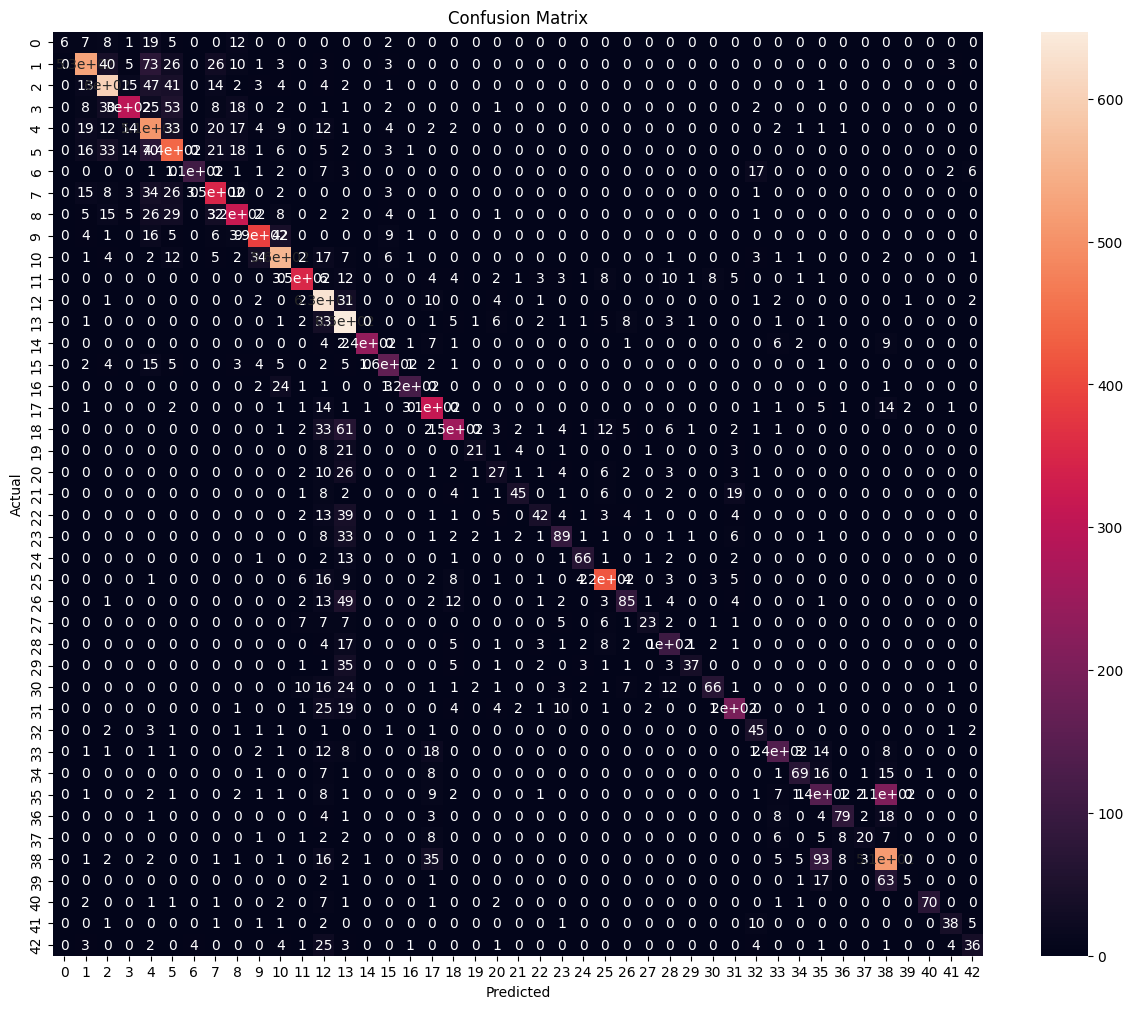

In [38]:
conf_matrix = confusion_matrix(y_test, pred_test)
plt.figure(figsize = (15, 12))
sns.heatmap(conf_matrix, annot = True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.grid(False)
plt.show()

Судя по матрице, в основном модель путается в первых 8 классах (они действительно очень похожи). Однако так же не мало ошибок и в других, самых разных классах.

In [41]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       1.00      0.10      0.18        60
           1       0.84      0.73      0.78       720
           2       0.79      0.80      0.80       750
           3       0.84      0.66      0.74       450
           4       0.60      0.77      0.67       660
           5       0.65      0.70      0.67       630
           6       0.96      0.73      0.83       150
           7       0.72      0.77      0.75       450
           8       0.75      0.70      0.73       450
           9       0.86      0.81      0.83       480
          10       0.82      0.85      0.83       660
          11       0.89      0.83      0.86       420
          12       0.64      0.92      0.75       690
          13       0.59      0.90      0.71       720
          14       0.99      0.88      0.93       270
          15       0.80      0.76      0.78       210
          16       0.95      0.79      0.86       150
          17       0.72    